# Excitation probability

Try and follow Baragiola *et al.* in their conventions:
\begin{align}
    \operatorname{Var}[\xi_t^2]
    &=
    \frac{1}{\Omega^2}
    \\
    \operatorname{Var}[\xi_t]
    &=
    \sigma_T^2=\frac{2}{\Omega^2}
    \\
    \operatorname{Var}[\xi_\omega^2]
    &=
    \Omega^2
    \\
    \operatorname{Var}[\xi_\omega]
    &=
    \sigma_\omega^2=\frac{\Omega^2}{2}
\end{align}

\begin{align}
    \xi_{t,\mathrm{gau}}&=\sqrt[4]{\frac{\Omega^2}{2\pi}}\exp\left(\frac{\Omega^2(t-t_a)^2}{4}\right)
\end{align}

In [1]:
from functools import partial
import pickle
import numpy as np
from scipy.integrate import quad

from tqdm import tqdm_notebook

import pysme.hierarchy as hier
import pysme.integrate as integ

import matplotlib.pyplot as plt
# #from quantum_utilities.qubits import Id, sigm, sigz, zero

In [2]:
# Define Lowering operator and Sigma Z

Id = np.eye(2, dtype=complex)

zero = np.zeros((2,2), dtype=complex)

sigz = np.array([[1, 0], [0, -1]], dtype=complex)

sigx = np.array([[0, 1], [1, 0]], dtype=complex)

sigy = np.array([[0, -1j], [1j, 0]], dtype=complex)

sigm = np.array([[0, 0], [1, 0]], dtype=complex)

In [3]:
def xi_gau(t, Omega, ta):
    return np.power(Omega**2/(2*np.pi), 1/4) * np.exp(-Omega**2*(t - ta)**2/4)

In [4]:
quad(lambda t: xi_gau(t, Omega=0.5, ta=0)**2, -3/0.5, 3/0.5)

(0.9973002039367399, 1.1072256503105314e-14)

In [5]:
rs = np.arcsinh(np.sqrt(np.arange(5)))
rs

array([0.        , 0.88137359, 1.14621583, 1.3169579 , 1.44363548])

In [6]:
np.exp(rs)

array([1.        , 2.41421356, 3.14626437, 3.73205081, 4.23606798])

In [7]:
np.sinh(rs)**2

array([0., 1., 2., 3., 4.])

In [8]:
Omegas = np.power(2, np.linspace(-3, 3, 7))
Omegas

array([0.125, 0.25 , 0.5  , 1.   , 2.   , 4.   , 8.   ])

In [9]:
S = Id
L = sigm
H = zero

In [10]:
rho0 = (Id + sigx)/2

In [11]:
n_max = 18
Omega = 1.21
r = 0.5012
factory = hier.HierarchyIntegratorFactory(2, n_max)

           
integrators = factory.make_uncond_integrator(partial(xi_gau, Omega=Omega, ta=0), S, L, H, r, mu=0)




times = np.linspace(-3/Omega, 3/Omega +2, 2**10+1)

solns = integrators.integrate(rho0, times)





In [12]:
# Broad band
phi = 0 #np.pi/2
M = - np.exp(2j*phi)* np.sinh(r) * np.cosh(r)
N = np.sinh(r)**2

asdf = integ.UncondGaussIntegrator(L, M, N, H)


In [13]:
markov_soln = asdf.integrate(rho0, times)
markov_soln.get_purities().shape

(1025,)

In [14]:
# with open('2019-11-19-bandwidth-me-solns.pickle', 'rb') as f:
#     solns = pickle.load(f)

In [15]:
def rect(x, a, b):
    return np.where(x < a, 0, np.where(x < b, 1, 0))

def rho_from_ket(ket):
    return np.outer(ket, ket.conj())

def vac_rho(n):
    ket = np.zeros(n + 1, dtype=np.complex)
    ket[0] = 1
    return rho_from_ket(ket)

In [16]:
solns.get_expectations(sigz, vac_rho(n_max)).shape
solns.get_purities(vac_rho(n_max)).shape

#times.shape

(1025,)

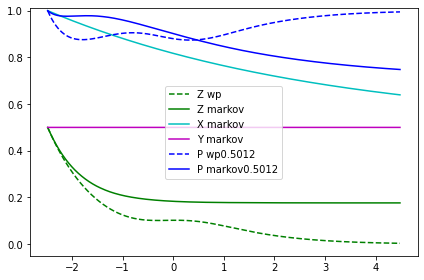

In [147]:

plt.plot(times, (solns.get_expectations(sigz, vac_rho(n_max)) + 1)/2,label='Z wp',linestyle='--',color='g')
plt.plot(times, (markov_soln.get_expectations(sigz) + 1)/2,label='Z markov',linestyle='-',color='g')
plt.plot(times, (markov_soln.get_expectations(sigx) + 1)/2,label='X markov',linestyle='-',color='c')
plt.plot(times, (markov_soln.get_expectations(sigy) + 1)/2,label='Y markov',linestyle='-',color='m')
plt.plot(times, solns.get_purities(vac_rho(n_max)),label='P wp' + str(r),linestyle='--',color='b')
plt.plot(times, markov_soln.get_purities(),label='P markov' + str(r), linestyle='-',color='b')
solns.get_purities(vac_rho(n_max))
plt.legend()
plt.ylim(-0.05, 1.01)
plt.tight_layout()

In [85]:
# fig, axs = plt.subplots(nrows=len(Omegas), ncols=len(rs), figsize=(10, 10), sharey=True)
# for Omega_idx, ax_row in enumerate(axs):
#     Omega = Omegas[Omega_idx]
#     times = np.linspace(-3/Omega, 3/Omega, 2**10 + 1)
#     for r_idx, ax in enumerate(ax_row):
#         ax.fill_between(times, xi_gau(times, Omega, 0)**2, color='k', alpha=0.125)
#         ax.plot(times,
#                 (solns[20,r_idx,Omega_idx].get_expectations(sigz, vac_rho(20)).flatten() + 1)/2)
#     ax_row[0].set_ylim(-0.05, 1.05)
# plt.tight_layout()